In [1]:
import os
import re
import glob

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
model_dir = 'imagenet'
images_dir = 'images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG|png', f)]

In [3]:
list_images

['images/0 2AAAAAA_25.jpg',
 'images/11 2AAAAAA_53.jpg',
 'images/CL0401_Recombination_0_2A_0.jpg',
 'images/CL0401_Recombination_0_2A_1.jpg',
 'images/CL0401_Recombination_0_2A_2.jpg',
 'images/CL0401_Recombination_0_2A_3.jpg']

In [4]:
!ls

Untitled.ipynb         inception_dec_2015     models
images                 inception_dec_2015.zip


In [5]:
def create_graph(model_path):
    with gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [14]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph('./inception_dec_2015/tensorflow_inception_graph.pb')

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        #return next_to_last_tensor
        for ind, image in enumerate(list_images):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()
            # print type(image_data)
            # print image_data.shape
            predictions = sess.run(next_to_last_tensor,
                {'DecodeJpeg/contents:0': image_data}
            )
            features[ind,:] = np.squeeze(predictions)
            # labels.append(re.split('_\d+', image.split('/')[1])[0])
            # print labels

    return features

In [15]:
features = extract_features(list_images)

Processing images/0 2AAAAAA_25.jpg...


In [16]:
features

array([[ 0.47068241,  0.08945829,  0.13366611, ...,  0.05383435,
         0.03009292,  0.63443828],
       [ 0.22226571,  0.08672577,  0.12418786, ...,  0.06292149,
         0.08584104,  0.27584559],
       [ 0.39227298,  0.07663888,  0.07541997, ...,  0.02165406,
         0.06384122,  0.87337971],
       [ 0.23266368,  0.0678314 ,  0.05158469, ...,  0.04112912,
         0.04910438,  0.96127439],
       [ 0.2510545 ,  0.09800744,  0.13347431, ...,  0.03023705,
         0.05948213,  0.9251731 ],
       [ 0.29402694,  0.10031941,  0.08089177, ...,  0.05623374,
         0.04242386,  0.84614938]])

In [17]:
def extract_features_from_dir(path):
    
    # filtered_images = path + '/.jpg'
    image_all = glob.glob(os.path.join(path, '*.jpg'))
    filtered_images = [image for image in image_all if 'Recombination' in image]

    return filtered_images

In [18]:
images = extract_features_from_dir('./images/CL0401/2A/CL0401_2A_c0/')

In [19]:
test = [dir_names for dir_names in os.listdir('./images/CL0401/2A/') if os.path.isdir(os.path.join('./images/CL0401/2A/', dir_names))]

In [20]:
np.array(list(test[0].split('_')[-1][1]) * 10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
def extract_features_from_angle(path):
    
    angle_dir_names = [dir_names for dir_names in os.listdir(path) if os.path.isdir(os.path.join(path, dir_names))]
    
    features_in_angle = []
    labels_in_angle = []
    for class_dir in angle_dir_names:
        
        
        images_list = extract_features_from_dir(os.path.join(path, class_dir))
        print 'there are {} images inside {}'.format(len(images_list), class_dir)
        # transform feature from exist model
        features = extract_features(images_list)
        labels = list(class_dir.split('_')[-1][1]) * len(images_list)
        
        # 
        features_in_angle.append(features)
        labels_in_angle.append(labels)
        
        # 
    features_final = np.concatenate(features_in_angle)
    labels_final = np.concatenate(labels_in_angle)
        
    return features_final, labels_final

In [ ]:
def extract_features_from_defect(path):
    

In [22]:
features, labels = extract_features_from_angle('./images/CL0401/2A/')

there are 26 images inside CL0401_2A_c0
Processing ./images/CL0401/2A/CL0401_2A_c0/CL0401_Recombination_0_2A_0.jpg...
there are 40 images inside CL0401_2A_c4
Processing ./images/CL0401/2A/CL0401_2A_c4/CL0401_Recombination_F3Y64930RR4H3RNA_2A_0.jpg...
there are 40 images inside CL0401_2A_c7
Processing ./images/CL0401/2A/CL0401_2A_c7/CL0401_Recombination_F3Y64750DCRH3RPA_2A_0.jpg...


In [23]:
features.shape

(106, 2048)

In [24]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7'], 
      dtype='|S1')

In [25]:
import os
import sklearn
from sklearn import cross_validation, grid_search
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib

/Users/hadoop1/.virtualenvs/cv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hadoop1/.virtualenvs/cv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
import os
import sklearn
from sklearn import cross_validation, grid_search
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib

def train_svm_classifier(features, labels, model_output_path):
    '''train a svm classifier and saved the SVM model, report the classification performance
    
    Notes:
    
    Args:
        features: array of input features
        labels: array of labels associated with the input features
        model_output_path: path for storing the trained svm model
    
    Return:
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, labels)
    
    params = [
        {
            "kernel": ["linear"],
            "C": [1, 10, 100, 1000]
        },
        {
            "kernel": ["rbf"],
            "C": [1, 10, 100, 1000],
            "gamma": [1e-2, 1e-3, 1e-4, 1e-5]
        }
    ]
    
    svm = SVC(probability=True)
    
    clf = grid_search.GridSearchCV(svm, params,
                                  cv=5, verbose=3)
    
    clf.fit(X_train, y_train)
    
    if os.path.exists(model_output_path):
        joblib.dump(clf.best_estimator_, model_output_path)
    else:
        print('Cannot save trained svm model to {}'.format(model_output_path))
        
    print("\nBest parameters set:")
    print(clf.best_estimator_)
    
    y_predict = clf.predict(X_test)
    labels=sorted(list(set(labels)))
    print("\nConfusion matrix:")
    print("Labels: {}\n".format(",".join(labels)))
    print(confusion_matrix(y_test, y_predict, labels=labels))
    
    print("\nClassification report:")
    print classification_report(y_test, y_predict)
    

In [28]:
train_svm_classifier(features, labels, './models/model.model')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.0s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.0s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.0s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.0s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.0s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.0s
[CV] kernel=linear, C=10 .............................................
[CV] ..........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.0s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.0s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.0s
[CV] kernel=linear, C=100 ............................................
[CV] ................... kernel=linear, C=100, score=1.000000 -   0.0s
[CV] kernel=linear, C=100 ............................................
[CV] ................... kernel=linear, C=100, score=1.000000 -   0.0s
[CV] kernel=linear, C=100 ............................................
[CV] ................... kernel=linear, C=100, score=1.000000 -   0.0s
[CV] kernel=linear, C=100 ............................................
[CV] ................... kernel=linear, C=100, score=1.000000 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished


In [30]:
features

array([[ 0.39227298,  0.07663888,  0.07541997, ...,  0.02165406,
         0.06384122,  0.87337971],
       [ 0.23266368,  0.0678314 ,  0.05158469, ...,  0.04112912,
         0.04910438,  0.96127439],
       [ 0.22793266,  0.0587802 ,  0.05655023, ...,  0.11125222,
         0.05073248,  0.83596504],
       ..., 
       [ 0.35035211,  0.02351124,  0.07087517, ...,  0.10144753,
         0.05265206,  0.33449203],
       [ 0.28047884,  0.03615147,  0.05085311, ...,  0.06710065,
         0.01601846,  0.28027076],
       [ 0.38363209,  0.05869427,  0.06008301, ...,  0.11713807,
         0.00221416,  0.32631245]])

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tsne import bh_sne

In [33]:
features.dtype

dtype('float64')

In [34]:
vis_data = bh_sne(features)

In [36]:
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

In [38]:
plt.style.use('ggplot')

In [42]:
features.shape

(106, 2048)

In [43]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7'], 
      dtype='|S1')

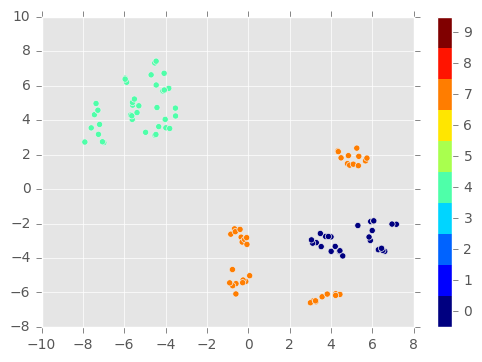

In [39]:
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [40]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7',
       '7', '7'], 
      dtype='|S1')

In [44]:
features, labels = extract_features_from_angle('./images/SH0401/2A/')

there are 286 images inside SH0401_2A_c0
Processing ./images/SH0401/2A/SH0401_2A_c0/SH0401_Recombination_0_2A_0.jpg...
Processing ./images/SH0401/2A/SH0401_2A_c0/SH0401_Recombination_14_2A_12.jpg...
Processing ./images/SH0401/2A/SH0401_2A_c0/SH0401_Recombination_5_2A_15.jpg...
there are 19 images inside SH0401_2A_c1
Processing ./images/SH0401/2A/SH0401_2A_c1/SH0401_Recombination_F3Y64840AZAGY4TA_2A_0.jpg...
there are 57 images inside SH0401_2A_c6
Processing ./images/SH0401/2A/SH0401_2A_c6/SH0401_Recombination_F3Y64920CWAGY4RA_2A_0.jpg...
there are 18 images inside SH0401_2A_c7
Processing ./images/SH0401/2A/SH0401_2A_c7/SH0401_Recombination_F3Y6495092JGY4TA_2A_0.jpg...


In [45]:
train_svm_classifier(features, labels, './model.model')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.1s
[CV] kernel=linear, C=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.1s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.1s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.1s
[CV] kernel=linear, C=1 ..............................................
[CV] ..................... kernel=linear, C=1, score=1.000000 -   0.1s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.1s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.1s
[CV] kernel=linear, C=10 .............................................
[CV] .................... kernel=linear, C=10, score=1.000000 -   0.1s
[CV] kernel=linear, C=10 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.5s finished


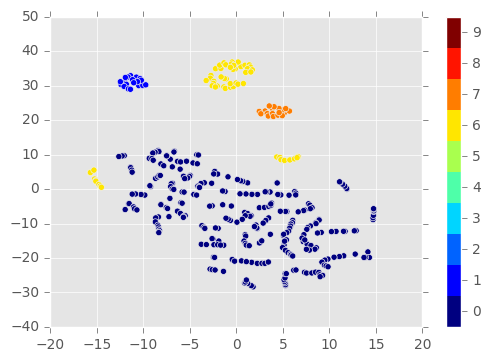

In [46]:
vis_data = bh_sne(features)
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()